In [389]:
import numpy as np
from numpy import linalg as la
from scipy.integrate import ode
from gekko import GEKKO

In [390]:
#define a model
m = GEKKO()
time_to_complete_motion = 6
film_time = time_to_complete_motion + 2
initial_pos = -1

In [391]:
#weight of the item
m2 = 1

In [392]:
#defining the time, beyond time_to_complete_motions (the end point)
m.time = np.linspace(0,film_time,100)
end_loc = int(100.0*time_to_complete_motion/film_time)

In [393]:
m1a = m.Param(value=10)
m2a = m.Param(value=m2)

final = np.zeros(len(m.time))

for i, v in enumerate(m.time):
    if v < time_to_complete_motion:
        final[i] = 0
    else:
        final[i] = 1
final = m.Param(value=final)

In [394]:
#MV
ua = m.Var(value=0)

#State Variables
the_a = m.Var(value=0)
qa = m.Var(value=0)
ya = m.Var(value=initial_pos)
va = m.Var(value=0)

#Intermediates
epsilon = m.Intermediate(m2a/(m1a+m2a))

#Defining the state space model
m.Equation(ya.dt() == va)
m.Equation(va.dt() == -epsilon*the_a + ua)
m.Equation(the_a.dt() == qa)
m.Equation(qa.dt() == the_a - ua)

In [395]:
#Make all state variables be zero at time >=time_to_complete_motion

m.Obj(final*ya**2)
m.Obj(final*va**2)
m.Obj(final*the_a**2)
m.Obj(final*qa**2)

m.fix(ya,pos=end_loc,val=0.0)
m.fix(va,pos=end_loc,val=0.0)
m.fix(the_a,pos=end_loc,val=0.0)
m.fix(qa,pos=end_loc,val=0.0)

In [396]:
#Try to minimize change of MV over all horizon
m.Obj(.001*ua**2)

m.options.IMODE = 6 #MPC
m.solve() #(disp=False)


apm 64.180.194.141_gk_model44 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            8
   Intermediates:            1
   Connections  :            8
   Equations    :           10
   Residuals    :            9
 
 Number of state variables:            883
 Number of total equations: -          792
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             91
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ip

MovieWriter ffmpeg unavailable; using Pillow instead.


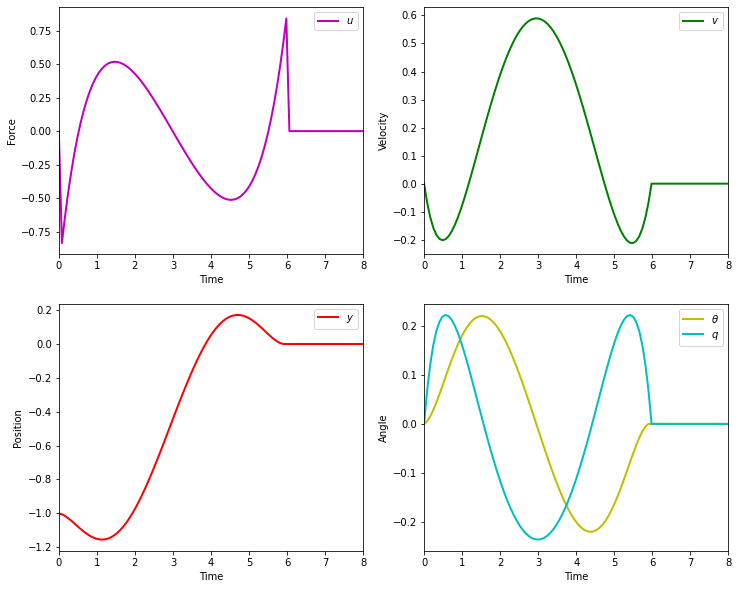

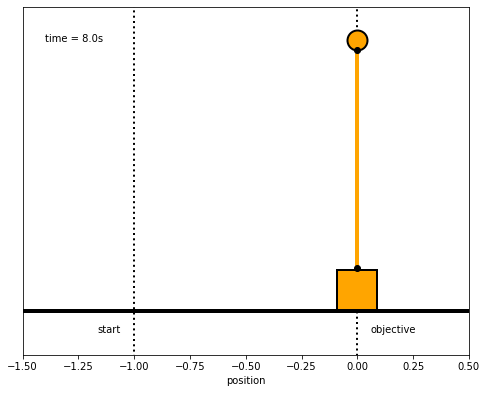

In [397]:
#Plotting the results
import matplotlib.pyplot as plt
from matplotlib import animation
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.plot(m.time,ua.value,'m',lw=2)
plt.legend([r'$u$'],loc=1)
plt.ylabel('Force')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(222)
plt.plot(m.time,va.value,'g',lw=2)
plt.legend([r'$v$'],loc=1)
plt.ylabel('Velocity')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(223)
plt.plot(m.time,ya.value,'r',lw=2)
plt.legend([r'$y$'],loc=1)
plt.ylabel('Position')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(224)
plt.plot(m.time,the_a.value,'y',lw=2)
plt.plot(m.time,qa.value,'c',lw=2)
plt.legend([r'$\theta$',r'$q$'],loc=1)
plt.ylabel('Angle')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.rcParams['animation.html'] = 'html5'

x1 = ya.value
y1 = np.zeros(len(m.time))

#suppose that l = 1
x2 = 1*np.sin(the_a.value)+x1
x2b = 1.05*np.sin(the_a.value)+x1
y2 = 1*np.cos(the_a.value)-y1
y2b = 1.05*np.cos(the_a.value)-y1

fig = plt.figure(figsize=(8,6.4))
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-1.5,0.5),ylim=(-0.4,1.2))
ax.set_xlabel('position')
ax.get_yaxis().set_visible(False)

crane_rail, = ax.plot([-1.5,0.5],[-0.2,-0.2],'k-',lw=4)
start, = ax.plot([-1,-1],[-1.5,1.5],'k:',lw=2)
objective, = ax.plot([0,0],[-0.5,1.5],'k:',lw=2)
mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='orange',lw=4,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)
start_text = ax.text(-1.06,-0.3,'start',ha='right')
end_text = ax.text(0.06,-0.3,'objective',ha='left')

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    return line, mass1, mass2, time_text

def animate(i):
    mass1.set_data([x1[i]],[y1[i]-0.1])
    mass2.set_data([x2b[i]],[y2b[i]])
    line.set_data([x1[i],x2[i]],[y1[i],y2[i]])
    time_text.set_text(time_template % m.time[i])
    return line, mass1, mass2, time_text

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(m.time)), \
         interval=40,blit=False,init_func=init)

# requires ffmpeg to save mp4 file
#  available from https://ffmpeg.zeranoe.com/builds/
#  add ffmpeg.exe to path such as C:\ffmpeg\bin\ in
#  environment variables

ani_a.save('Pendulum_Control.gif',fps=30)